In [1]:
%matplotlib inline
import pandas as pd
import warnings
import os
import csv
import numpy as np
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import time
from sklearn.metrics import mean_squared_error
warnings.filterwarnings(action='ignore')


## 读取数据

In [2]:
def readBuyPrices(source_path):
    resultDict = {}
    for root, _, files in os.walk(source_path):
        for file in files:
            category = file.split('统计')[0]
            filename = os.path.join(root, file)
            data = pd.read_csv(filename,index_col=0)
            data.index = pd.to_datetime(data.index)
            data.columns = ['批发价格']
            data.head()
            resultDict[category] = data
    return resultDict

In [3]:
rawBuyPricesDict = readBuyPrices("D:\Git\国赛\data\批发销售数据_品类")

## 异常值处理

In [4]:
def processAbnormalData(source_dict):
    result_dict = {}
    for key, item in source_dict.items():
        new_item = item.fillna(0)
        result_dict[key] = new_item
    return result_dict

In [5]:
processedBuyPricesDict = processAbnormalData(rawBuyPricesDict)

## 划分数据集

In [6]:
# 创建一个示例的DatetimeIndex和DataFrame
def spiltDataset(source_dict):
    result_dict = {}
    date_rng = pd.date_range(start='2020-07-01', end='2023-06-30')
    for key, item in source_dict.items():
        df = pd.DataFrame(item, index=date_rng)
        print(key)
        print(df)
        result_dict[key] = df
    return result_dict

In [12]:
spiltBuyPricesDict = spiltDataset(processedBuyPricesDict)

水生根茎类
                批发价格
2020-07-01  0.013349
2020-07-02  0.012989
2020-07-03  0.002693
2020-07-04  0.069630
2020-07-05  0.005013
...              ...
2023-06-26  0.000000
2023-06-27  0.000000
2023-06-28  0.000000
2023-06-29  0.000000
2023-06-30  0.000000

[1095 rows x 1 columns]
花叶类
                批发价格
2020-07-01  0.010922
2020-07-02  0.010332
2020-07-03  0.008928
2020-07-04  0.013575
2020-07-05  0.008162
...              ...
2023-06-26  0.000000
2023-06-27  0.000000
2023-06-28  0.000000
2023-06-29  0.000000
2023-06-30  0.000000

[1095 rows x 1 columns]
花菜类
                批发价格
2020-07-01  0.014201
2020-07-02  0.013535
2020-07-03  0.011873
2020-07-04  0.017127
2020-07-05  0.013026
...              ...
2023-06-26  0.000000
2023-06-27  0.000000
2023-06-28  0.000000
2023-06-29  0.000000
2023-06-30  0.000000

[1095 rows x 1 columns]
茄类
                批发价格
2020-07-01  0.013407
2020-07-02  0.012209
2020-07-03  0.011667
2020-07-04  0.015722
2020-07-05  0.013617
...              ...
2023-

In [17]:
def packDataset(source_dict, trainMonthSize):
    train_dict = {}
    valid_dict = {}
    for key, item in source_dict.items():
        # 创建train_lst和valid_lst用于存放数据
        train_list = []
        valid_list = []

        # 定义起始和结束日期
        startDate = pd.to_datetime('2020-07-01')
        endDate = pd.to_datetime('2023-06-30')

        # 遍历日期范围，以每个月为单位提取数据
        currentDate = startDate

        while currentDate <= endDate:
            # 提取train数据（当前月）
            trainEndDate = currentDate + pd.DateOffset(months=trainMonthSize - 1, day=31)
            print('START ')
            print(currentDate)
            print('END ')
            print(trainEndDate)
            trainData = item[currentDate:trainEndDate]
            # print(f"data: {current_date}")
            # print(train_data)
            train_list.append(trainData)

            # 提取valid数据（下个月的1日到月底）

            valid_startDate = trainEndDate + pd.DateOffset(months=1, day=1)
            valid_endDate = valid_startDate + pd.DateOffset(months=0, day=31)
            validData = item[valid_startDate:valid_endDate]
            valid_list.append(validData)

            # 更新当前日期为下个月
            nextMonth = currentDate + pd.DateOffset(months=1)
            currentDate = nextMonth

        # 打印train_lst和valid_lst中的数据
        for trainIndex, (trainData, validData) in enumerate(zip(train_list, valid_list), start=1):
            print(f"Class {trainIndex} - Train Data:")
            print(trainData)
            print(f"Class {trainIndex} - Valid Data:")
            print(validData)
            print("-" * 50)
        train_dict[key] = train_list
        valid_dict[key] = valid_list
    return train_dict, valid_dict

In [18]:
# 训练集月数
train_month_size = 4

trainSetDict, validSetDict = packDataset(spiltBuyPricesDict, train_month_size)

START 
2020-07-01 00:00:00
END 
2020-10-31 00:00:00
START 
2020-08-01 00:00:00
END 
2020-11-30 00:00:00
START 
2020-09-01 00:00:00
END 
2020-12-31 00:00:00
START 
2020-10-01 00:00:00
END 
2021-01-31 00:00:00
START 
2020-11-01 00:00:00
END 
2021-02-28 00:00:00
START 
2020-12-01 00:00:00
END 
2021-03-31 00:00:00
START 
2021-01-01 00:00:00
END 
2021-04-30 00:00:00
START 
2021-02-01 00:00:00
END 
2021-05-31 00:00:00
START 
2021-03-01 00:00:00
END 
2021-06-30 00:00:00
START 
2021-04-01 00:00:00
END 
2021-07-31 00:00:00
START 
2021-05-01 00:00:00
END 
2021-08-31 00:00:00
START 
2021-06-01 00:00:00
END 
2021-09-30 00:00:00
START 
2021-07-01 00:00:00
END 
2021-10-31 00:00:00
START 
2021-08-01 00:00:00
END 
2021-11-30 00:00:00
START 
2021-09-01 00:00:00
END 
2021-12-31 00:00:00
START 
2021-10-01 00:00:00
END 
2022-01-31 00:00:00
START 
2021-11-01 00:00:00
END 
2022-02-28 00:00:00
START 
2021-12-01 00:00:00
END 
2022-03-31 00:00:00
START 
2022-01-01 00:00:00
END 
2022-04-30 00:00:00
START 
2022-

## ARIMA模型

In [21]:
def trainARIMA(source_train_dict: dict, source_valid_dict: dict, train_month_length: int):
    models_dict = {}
    rmse_dict = {}
    for key, item in source_train_dict.items():
        key_start = time.time()
        print("\n\nKey", key)
        # 训练测试集提取
        train_lst = item
        valid_lst = source_valid_dict[key]

        # 参数
        epochs = 1
        d_values_to_try = [1, 2] # 尝试不同的d值

        # 假设你有一个包含m组单维数据的列表
        m = len(train_lst)
        best_models = []  # 用于存储每组数据的最佳模型
        best_d = None
        best_rmse = np.inf
        best_stepwise_model = None
        stepwise_model = None
        # 开始epoch
        for epoch in range(epochs):
            print("\n\nEpoch: {}/{} ".format(epoch, epochs))
            print("Key", key)
            # 记录程序开始时间
            start_time = time.time()
            for i in range(m - train_month_length - 2):
                print("\n\nEpoch: {}/{} ".format(epoch, epochs))
                print("Col: {}/{} ".format(i, (m - 1)))
                print("Key", key)
                dimension_start = time.time()
                # 初始化每组数据的最佳模型

                # 第一步: 对每组数据训练自动ARIMA模型
                for d in d_values_to_try:
                    stepwise_model = auto_arima(train_lst[i], start_p=1, start_q=1,
                                                max_p=3, max_q=3, m=12,
                                                start_P=0, seasonal=True,
                                                d=d, D=1, trace=True,
                                                error_action='ignore',
                                                suppress_warnings=True,
                                                stepwise=True)

                    # 第二步: 在验证集上进行预测
                    forecast = stepwise_model.predict(n_periods=len(valid_lst[i]))

                    # 第三步: 计算RMSE
                    rmse_new = np.sqrt(mean_squared_error(valid_lst[i], forecast))

                    if rmse_new < best_rmse:
                        best_rmse = rmse_new
                        best_d = d
                        best_stepwise_model = stepwise_model
                        # best_model_index = (epoch + 1)*i

                    print(f'RMSE for group {i + 1} with d={d}: {rmse_new}')

                # 存储每组数据的最佳模型
                best_models.append(best_stepwise_model)
                # 记录程序结束时间
                dimension_end = time.time()

                # 计算程序运行时间（以秒为单位）
                dimension_run_time = dimension_end - dimension_start
                print(f"Col run time: {dimension_run_time}s")
            # 记录程序结束时间
            end_time = time.time()

            # 计算程序运行时间（以秒为单位）
            run_time = end_time - start_time
            print(f"Epoch：{epoch + 1} 运行{run_time}s")
            print(f'Best d for epoch {epoch + 1}: {best_d}')
            print(f'Best RMSE for epoch {epoch + 1}: {best_rmse}')


        models_dict[key] = stepwise_model
        rmse_dict[key] = best_rmse

        key_end = time.time()
        key_time = key_end - key_start
        print(f"Key：{key} 运行{key_time}s")
    return models_dict, rmse_dict

In [22]:
# 训练集月数
# train_month_size = 4
modelsDict, rmseDict = trainARIMA(trainSetDict, validSetDict, train_month_size)
rmseDict



Key 水生根茎类


Epoch: 0/1 
Key 水生根茎类


Epoch: 0/1 
Col: 0/35 
Key 水生根茎类
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-229.927, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-297.200, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-263.219, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-305.273, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-282.438, Time=0.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-303.301, Time=0.65 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-304.595, Time=0.98 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-313.215, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-300.428, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]           

{'水生根茎类': 0.010369646213586187,
 '花叶类': 0.001709641796854374,
 '花菜类': 0.002491903474105417,
 '茄类': 0.0017124722333939461,
 '辣椒类': 0.0015568463200052384,
 '食用菌': 0.0007793795940360211}

In [26]:
with open(r'D:\Git\国赛\result\Q2\ARIMA最优模型参数选择.txt', 'w', encoding='utf-8', newline='') as file:
    # 打开文件以写入，如果文件不存在则创建

    file.write('This is a new line.\n')
    for key, item in modelsDict.items():
        print(key + "ARIMA 最优模型参数:")
        print("p, d, q: ", str(item.order))
        print('Smallest RMSE:' + str(rmseDict[key]))
        file.write(key + "ARIMA 最优模型参数:\n")
        file.write("\tp, d, q: "+ str(item.order) + '\n')
        file.write('\tSmallest RMSE:' + str(rmseDict[key]) + '\n')

水生根茎类ARIMA 最优模型参数:
p, d, q:  (3, 2, 0)
Smallest RMSE:0.010369646213586187
花叶类ARIMA 最优模型参数:
p, d, q:  (3, 2, 1)
Smallest RMSE:0.001709641796854374
花菜类ARIMA 最优模型参数:
p, d, q:  (2, 2, 1)
Smallest RMSE:0.002491903474105417
茄类ARIMA 最优模型参数:
p, d, q:  (2, 2, 1)
Smallest RMSE:0.0017124722333939461
辣椒类ARIMA 最优模型参数:
p, d, q:  (2, 2, 2)
Smallest RMSE:0.0015568463200052384
食用菌ARIMA 最优模型参数:
p, d, q:  (1, 2, 3)
Smallest RMSE:0.0007793795940360211


### 检验平稳性

In [27]:
# Dickey-Fuller test:
def testStationarity(ts,max_lag = None):
    dftest = statsmodels.tsa.stattools.adfuller(ts,maxlag= max_lag)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [29]:
max_train_index =len(trainSetDict)
for key, item in trainSetDict.items():
    if modelsDict[key].order[1] == 1:
        # print()
        temp_item_1 = np.diff(item[0])
        print("Category {}:  diff{}".format(key, modelsDict[key].order[1]))
        testStationarity(temp_item_1)
    else:
        # print(item[0]['批发价格'])
        temp_item_1 = np.diff(item[0]['批发价格'])
        temp_item_2 = np.diff(temp_item_1)
        print("Category {}:  diff{}".format(key, modelsDict[key].order[1]))
        # print(temp_item_2)
        print(testStationarity(temp_item_2))

Category 水生根茎类:  diff2
Test Statistic                -9.687533e+00
p-value                        1.159766e-16
#Lags Used                     7.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
Category 花叶类:  diff2
Test Statistic                -5.673451e+00
p-value                        8.814018e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64
Category 花菜类:  diff2
Test Statistic                -6.057564e+00
p-value                        1.234645e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)     

 ### 填补5-6月空缺值

In [384]:
# 创建日期范围
date_range1_1 = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
date_range1_2 = pd.date_range(start='2023-06-01', end='2023-06-30', freq='D')
date_range2 = pd.date_range(start='2023-07-01', end='2023-07-07', freq='D')
# 创建数据
temp_data1_1 = {
    '批发价格': [0]*len(date_range1_1)
}
temp_data1_2 = {
    '批发价格': [0]*len(date_range1_2)
}
temp_data2 = {
    '批发价格': [0]*len(date_range2)
}
# 创建 DataFrame
target_predict1_1 = pd.DataFrame(temp_data1_1, index=date_range1_1)
target_predict1_2 = pd.DataFrame(temp_data1_2, index=date_range1_2)
target_predict2 = pd.DataFrame(temp_data2, index=date_range2)
target_predict1_1.index.name = "日期"
target_predict1_2.index.name = "日期"
target_predict2.index.name = "日期"

In [422]:
def predictBuyPrices(model_dict, train_dict, target_predict_lst, savingFolder, predictMonth):
    forecast_dict = {}
    for key, item in model_dict.items():
        train_lst = train_dict[key]
        # valid_lst = valid_dict[key]
        # 假设你已经有了最佳的stepwise_model和相应的最佳d值
        best_stepwise_model = item
        best_p, best_d, best_q = best_stepwise_model.order

        # 准备你要进行预测的数据
        # 例如，你有一个名为test_data的数据列表
        # 假设你希望使用模型来预测test_data

        # 重新训练模型（使用最佳d值）
        retrained_stepwise_model = ARIMA(train_lst[predictMonth-11], order=(best_p, best_d, best_q))

        # 估计模型的参数
        retrained_stepwise_model_fit = retrained_stepwise_model.fit()
        # print(train_lst[predictMonth-11])
        # print(len(train_lst[predictMonth-11]))
        # print(len(train_lst[predictMonth-11]) + len(target_predict_lst) - 1)
        # 在测试集上进行预测
        # valid_forecast = retrained_stepwise_model_fit.predict(start=len(train_lst), end=len(train_lst) + len(valid_lst) - 1, typ='levels')
        predict_lst = retrained_stepwise_model_fit.predict(start=0, end=len(train_lst[predictMonth-11]) - 1, typ='levels')
        forecast = retrained_stepwise_model_fit.predict(start=len(train_lst[predictMonth-11]), end=len(train_lst[predictMonth-11]) + len(target_predict_lst) - 1, typ='levels')
        print(forecast)
        forecast_dict[key] = forecast
        # 计算预测的均方根误差
        rmse = np.sqrt(mean_squared_error(train_lst[predictMonth-11], predict_lst))
        print(f'RMSE on test data: {rmse}')

        # 如果需要，你可以绘制预测结果


        plt.plot(train_lst[predictMonth-11], label='Original')
        plt.plot(predict_lst, label='Predict', color='green')
        plt.plot(forecast, label='Forecast', color='red')
        plt.xlabel('Time')
        plt.ylabel('Sales Volumes')
        plt.legend()
        months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        plt.title(f'{months[predictMonth - 1]} Prediction')
        pic_filename = os.path.join(savingFolder, key + f'_{months[predictMonth - 1]}_批发价填充.jpg')
        plt.savefig(pic_filename)
        plt.show()
    return forecast_dict

#### 5月

2023-05-01    0.145882
2023-05-02    0.145756
2023-05-03    0.145672
2023-05-04    0.145533
2023-05-05    0.145398
2023-05-06    0.145285
2023-05-07    0.145160
2023-05-08    0.145033
2023-05-09    0.144910
2023-05-10    0.144787
2023-05-11    0.144662
2023-05-12    0.144538
2023-05-13    0.144414
2023-05-14    0.144290
2023-05-15    0.144166
2023-05-16    0.144042
2023-05-17    0.143918
2023-05-18    0.143794
2023-05-19    0.143670
2023-05-20    0.143546
2023-05-21    0.143422
2023-05-22    0.143298
2023-05-23    0.143174
2023-05-24    0.143050
2023-05-25    0.142926
2023-05-26    0.142801
2023-05-27    0.142677
2023-05-28    0.142553
2023-05-29    0.142429
2023-05-30    0.142305
2023-05-31    0.142181
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.05532648324492144


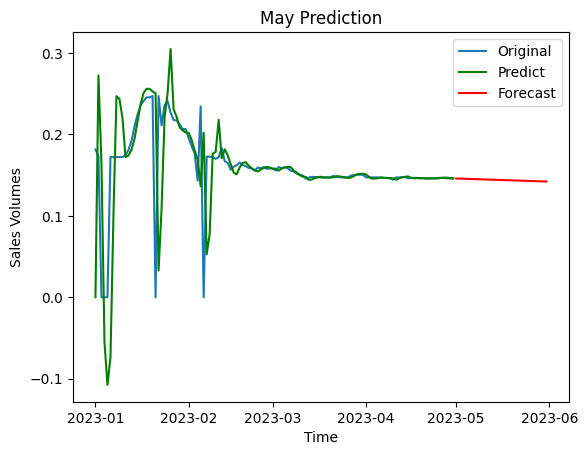

2023-05-01    0.022499
2023-05-02    0.022473
2023-05-03    0.022468
2023-05-04    0.022460
2023-05-05    0.022464
2023-05-06    0.022454
2023-05-07    0.022448
2023-05-08    0.022441
2023-05-09    0.022439
2023-05-10    0.022432
2023-05-11    0.022427
2023-05-12    0.022420
2023-05-13    0.022416
2023-05-14    0.022410
2023-05-15    0.022405
2023-05-16    0.022399
2023-05-17    0.022394
2023-05-18    0.022388
2023-05-19    0.022383
2023-05-20    0.022377
2023-05-21    0.022372
2023-05-22    0.022366
2023-05-23    0.022361
2023-05-24    0.022355
2023-05-25    0.022350
2023-05-26    0.022345
2023-05-27    0.022339
2023-05-28    0.022334
2023-05-29    0.022328
2023-05-30    0.022323
2023-05-31    0.022317
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.00782119971791907


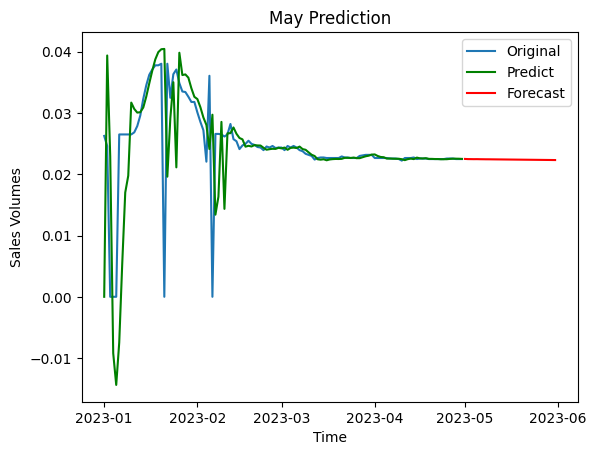

2023-05-01    0.054814
2023-05-02    0.054967
2023-05-03    0.055812
2023-05-04    0.055595
2023-05-05    0.055591
2023-05-06    0.055934
2023-05-07    0.056022
2023-05-08    0.056085
2023-05-09    0.056267
2023-05-10    0.056404
2023-05-11    0.056511
2023-05-12    0.056652
2023-05-13    0.056789
2023-05-14    0.056914
2023-05-15    0.057046
2023-05-16    0.057180
2023-05-17    0.057310
2023-05-18    0.057441
2023-05-19    0.057573
2023-05-20    0.057704
2023-05-21    0.057836
2023-05-22    0.057967
2023-05-23    0.058099
2023-05-24    0.058230
2023-05-25    0.058362
2023-05-26    0.058493
2023-05-27    0.058624
2023-05-28    0.058756
2023-05-29    0.058887
2023-05-30    0.059019
2023-05-31    0.059150
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.012013890859845949


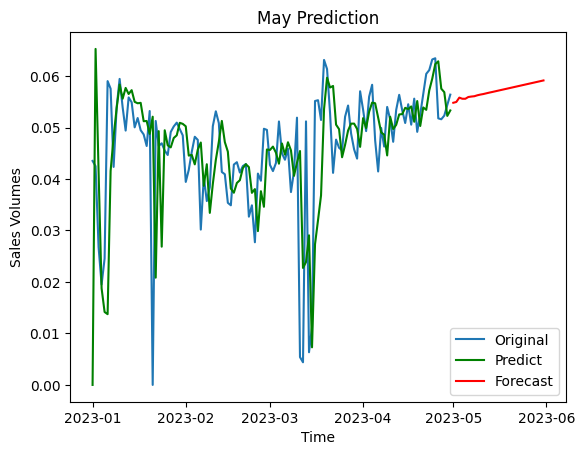

2023-05-01    0.050646
2023-05-02    0.051011
2023-05-03    0.051529
2023-05-04    0.051322
2023-05-05    0.051458
2023-05-06    0.051659
2023-05-07    0.051705
2023-05-08    0.051813
2023-05-09    0.051941
2023-05-10    0.052037
2023-05-11    0.052143
2023-05-12    0.052255
2023-05-13    0.052360
2023-05-14    0.052467
2023-05-15    0.052575
2023-05-16    0.052682
2023-05-17    0.052789
2023-05-18    0.052897
2023-05-19    0.053004
2023-05-20    0.053111
2023-05-21    0.053219
2023-05-22    0.053326
2023-05-23    0.053433
2023-05-24    0.053541
2023-05-25    0.053648
2023-05-26    0.053755
2023-05-27    0.053863
2023-05-28    0.053970
2023-05-29    0.054077
2023-05-30    0.054184
2023-05-31    0.054292
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.009449928526768769


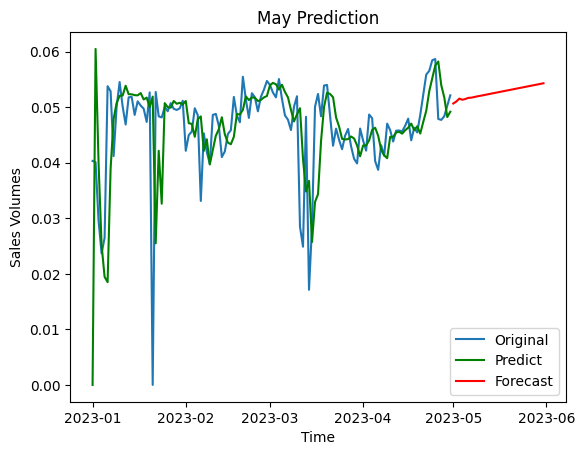

2023-05-01    0.038438
2023-05-02    0.038888
2023-05-03    0.039107
2023-05-04    0.038983
2023-05-05    0.039256
2023-05-06    0.039321
2023-05-07    0.039406
2023-05-08    0.039558
2023-05-09    0.039643
2023-05-10    0.039760
2023-05-11    0.039876
2023-05-12    0.039979
2023-05-13    0.040094
2023-05-14    0.040205
2023-05-15    0.040314
2023-05-16    0.040426
2023-05-17    0.040537
2023-05-18    0.040648
2023-05-19    0.040759
2023-05-20    0.040869
2023-05-21    0.040980
2023-05-22    0.041091
2023-05-23    0.041202
2023-05-24    0.041313
2023-05-25    0.041423
2023-05-26    0.041534
2023-05-27    0.041645
2023-05-28    0.041756
2023-05-29    0.041867
2023-05-30    0.041978
2023-05-31    0.042088
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.007276789320555795


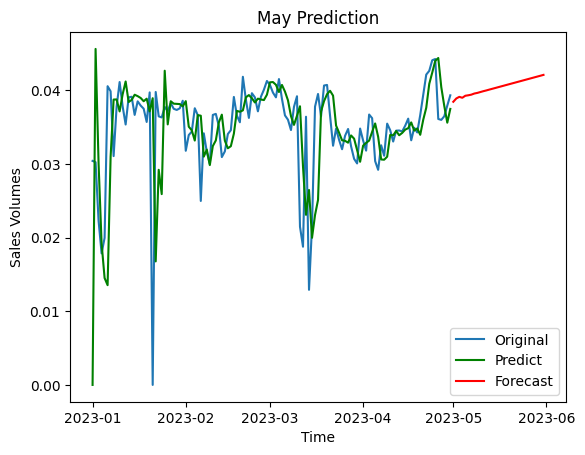

2023-05-01    0.027597
2023-05-02    0.027614
2023-05-03    0.027720
2023-05-04    0.027739
2023-05-05    0.027844
2023-05-06    0.027865
2023-05-07    0.027968
2023-05-08    0.027991
2023-05-09    0.028092
2023-05-10    0.028116
2023-05-11    0.028216
2023-05-12    0.028242
2023-05-13    0.028340
2023-05-14    0.028367
2023-05-15    0.028464
2023-05-16    0.028493
2023-05-17    0.028588
2023-05-18    0.028618
2023-05-19    0.028712
2023-05-20    0.028744
2023-05-21    0.028836
2023-05-22    0.028869
2023-05-23    0.028960
2023-05-24    0.028995
2023-05-25    0.029084
2023-05-26    0.029120
2023-05-27    0.029208
2023-05-28    0.029245
2023-05-29    0.029332
2023-05-30    0.029371
2023-05-31    0.029457
Freq: D, Name: predicted_mean, dtype: float64
RMSE on test data: 0.005059351489111074


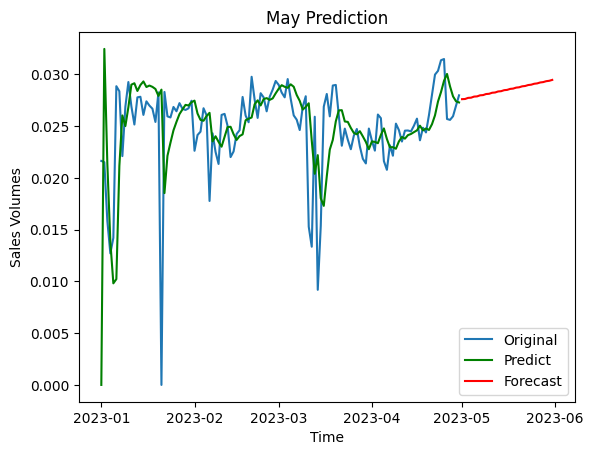

In [423]:
saving_path_null = r'D:\Git\国赛\result\Q2\批发价预测\5-6月\picture'
# 填充5月空缺
fillnullDictMon5 = predictBuyPrices(modelsDict, trainSetDict, target_predict1_1, saving_path_null, 5)

#### 将5月份的数据填充到缺失值

In [425]:
# TODO
def fillProcessBuyPricesDict(processed_dict: dict, fillNullDict: dict):
    # 预测数据
    df = pd.DataFrame(columns=['日期', 'predicted_mean'])
    dict1 = processed_dict.copy()
    dict2 = fillNullDict.copy()
    for kind, series in dict1.items():

        name = kind
        df_kind_1 = pd.DataFrame(series)
        fillNullLst = fillNullDict[kind]
        df_kind_2 = pd.DataFrame(fillNullLst)
        df_kind_1.reset_index(drop=True)
        df_kind_2.reset_index(drop=True)
        for date, row in df_kind_1.iterrows():
            # date = row[0]
            original_value = row[0]
            for modified_date, modified_row in df_kind_2.iterrows():

                if date == modified_date:
                    # print("YES")
                    # print(date)
                    # print(modified_date)
                    #
                    # print('Original_value: ', original_value)
                    # print('Modified_date:', modified_row['predicted_mean'])

                # else:
                #     print("")
                    if original_value<=0:
                        print("Before modifiled, Original_value: ", row[0])
                        if modified_row['predicted_mean']>=0:
                            row[0] = modified_row['predicted_mean']
                        else:
                            original_value = 0
                        print("After modifiled, Original_value: ", row[0])
    return dict1

In [426]:
# 数据集更新
processedBuyPricesDict_filled5 = fillProcessBuyPricesDict(processedBuyPricesDict, fillnullDictMon5)

In [427]:
# 划分更新数据集
train_month_size = 4
spiltBuyPricesDict_filled5 = spiltDataset(processedBuyPricesDict_filled5)
trainSetDict_filled5, validSetDict_filled5 = packDataset(spiltBuyPricesDict, train_month_size)

水生根茎类
                批发价格
2020-07-01  0.013349
2020-07-02  0.012989
2020-07-03  0.002693
2020-07-04  0.069630
2020-07-05  0.005013
...              ...
2023-06-26  0.138956
2023-06-27  0.138831
2023-06-28  0.138707
2023-06-29  0.138583
2023-06-30  0.138459

[1095 rows x 1 columns]
花叶类
                批发价格
2020-07-01  0.010922
2020-07-02  0.010332
2020-07-03  0.008928
2020-07-04  0.013575
2020-07-05  0.008162
...              ...
2023-06-26  0.022175
2023-06-27  0.022170
2023-06-28  0.022164
2023-06-29  0.022159
2023-06-30  0.022153

[1095 rows x 1 columns]
花菜类
                批发价格
2020-07-01  0.014201
2020-07-02  0.013535
2020-07-03  0.011873
2020-07-04  0.017127
2020-07-05  0.013026
...              ...
2023-06-26  0.063045
2023-06-27  0.063195
2023-06-28  0.063344
2023-06-29  0.063493
2023-06-30  0.063643

[1095 rows x 1 columns]
茄类
                批发价格
2020-07-01  0.013407
2020-07-02  0.012209
2020-07-03  0.011667
2020-07-04  0.015722
2020-07-05  0.013617
...              ...
2023-

#### 预测6月

In [ ]:
# 填充6月空缺
fillnullDictMon6 = predictBuyPrices(modelsDict, trainSetDict_filled5, target_predict1_2, saving_path_null, 6)

In [429]:
# 数据集更新
processedBuyPricesDict_filled6 = fillProcessBuyPricesDict(processedBuyPricesDict_filled5, fillnullDictMon6)

In [430]:
# 划分更新数据集
train_month_size = 4
spiltBuyPricesDict_filled6 = spiltDataset(processedBuyPricesDict_filled6)
trainSetDict_filled6, validSetDict_filled6 = packDataset(spiltBuyPricesDict_filled6, train_month_size)

水生根茎类
                批发价格
2020-07-01  0.013349
2020-07-02  0.012989
2020-07-03  0.002693
2020-07-04  0.069630
2020-07-05  0.005013
...              ...
2023-06-26  0.138956
2023-06-27  0.138831
2023-06-28  0.138707
2023-06-29  0.138583
2023-06-30  0.138459

[1095 rows x 1 columns]
花叶类
                批发价格
2020-07-01  0.010922
2020-07-02  0.010332
2020-07-03  0.008928
2020-07-04  0.013575
2020-07-05  0.008162
...              ...
2023-06-26  0.022175
2023-06-27  0.022170
2023-06-28  0.022164
2023-06-29  0.022159
2023-06-30  0.022153

[1095 rows x 1 columns]
花菜类
                批发价格
2020-07-01  0.014201
2020-07-02  0.013535
2020-07-03  0.011873
2020-07-04  0.017127
2020-07-05  0.013026
...              ...
2023-06-26  0.063045
2023-06-27  0.063195
2023-06-28  0.063344
2023-06-29  0.063493
2023-06-30  0.063643

[1095 rows x 1 columns]
茄类
                批发价格
2020-07-01  0.013407
2020-07-02  0.012209
2020-07-03  0.011667
2020-07-04  0.015722
2020-07-05  0.013617
...              ...
2023-

## 预测7月1-7日

In [431]:
forecast_target = target_predict2

In [438]:
def forecastBuyPrices(model_dict, train_dict, target_predict_lst, savingFolder, predictMonth):
    forecast_dict = {}
    for key, item in model_dict.items():
        train_lst = train_dict[key]
        # valid_lst = valid_dict[key]
        # 假设你已经有了最佳的stepwise_model和相应的最佳d值
        best_stepwise_model = item
        best_p, best_d, best_q = best_stepwise_model.order

        # 准备你要进行预测的数据
        # 例如，你有一个名为test_data的数据列表
        # 假设你希望使用模型来预测test_data

        # 重新训练模型（使用最佳d值）
        retrained_stepwise_model = ARIMA(train_lst[predictMonth-11], order=(best_p, best_d, best_q))

        # 估计模型的参数
        retrained_stepwise_model_fit = retrained_stepwise_model.fit()
        # print(train_lst[predictMonth-11])
        # print(len(train_lst[predictMonth-11]))
        # print(len(train_lst[predictMonth-11]) + len(target_predict_lst) - 1)
        # 在测试集上进行预测
        # valid_forecast = retrained_stepwise_model_fit.predict(start=len(train_lst), end=len(train_lst) + len(valid_lst) - 1, typ='levels')
        predict_lst = retrained_stepwise_model_fit.predict(start=0, end=len(train_lst[predictMonth-11]) - 1, typ='levels')
        forecast = retrained_stepwise_model_fit.predict(start=len(train_lst[predictMonth-11]), end=len(train_lst[predictMonth-11]) + len(target_predict_lst) - 1, typ='levels')
        print(forecast)
        forecast_dict[key] = forecast
        # 计算预测的均方根误差
        rmse = np.sqrt(mean_squared_error(train_lst[predictMonth-11], predict_lst))
        print(f'RMSE on test data: {rmse}')

        # 如果需要，你可以绘制预测结果

        plt.figure(figsize=(12, 8))
        plt.plot(train_lst[predictMonth-11], label='Original')
        plt.plot(predict_lst, label='Predict', color='green')
        plt.plot(forecast, label='Forecast', color='red')
        plt.xlabel('Time')
        plt.ylabel('Sales Volumes')
        plt.legend()
        months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        plt.title(f'{months[predictMonth - 1]} Forecast')
        pic_filename = os.path.join(savingFolder, key + f'_{months[predictMonth - 1]}_批发价预测.jpg')
        plt.savefig(pic_filename)
        plt.show()
    return forecast_dict

In [ ]:
saving_path_forecast = r'D:\Git\国赛\result\Q2\批发价预测\7月\picture'
# 填充空缺
forecastDict_1 = forecastBuyPrices(modelsDict, trainSetDict_filled6, forecast_target, saving_path_forecast, 7)

## Write Files

5-6月结果

In [450]:
header = ['日期', '批发价']

In [454]:
for key, item in fillnullDictMon5.items():
    df_item = pd.DataFrame(item)
    df_item.reset_index(drop=True)
    filename = os.path.join(r'D:\Git\国赛\result\Q2\批发价预测\5-6月\result_data', key + '_5月预测批发价.csv')
    with open(filename, 'w', encoding = 'UTF-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for date, row in df_item.iterrows():
            writer.writerow([date, row[0]])

In [455]:
for key, item in fillnullDictMon6.items():
    df_item = pd.DataFrame(item)
    df_item.reset_index(drop=True)
    filename = os.path.join(r'D:\Git\国赛\result\Q2\批发价预测\5-6月\result_data', key + '_6月预测批发价.csv')
    with open(filename, 'w', encoding = 'UTF-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for date, row in df_item.iterrows():
            writer.writerow([date, row[0]])

7月结果

In [442]:
header = ['批发价']
for key, item in forecastDict_1.items():
    print(key)
    filename = os.path.join(r'D:\Git\国赛\result\Q2\批发价预测\7月\result_data', key + '_7月预测批发价.csv')
    with open(filename, 'w', encoding = 'UTF-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for index, value in enumerate(item):
            writer.writerow([value])

水生根茎类
花叶类
花菜类
茄类
辣椒类
食用菌


# DEBUG使用(无需运行)

In [82]:
def linear_interpolation(input_list):
    interpolated_list = input_list.copy()
    for i in range(len(interpolated_list)):
        if interpolated_list[i] == 0:
            # 寻找前后非零值的索引
            left_idx = i - 1
            while left_idx >= 0 and interpolated_list[left_idx] == 0:
                left_idx -= 1
            right_idx = i + 1
            while right_idx < len(interpolated_list) and interpolated_list[right_idx] == 0:
                right_idx += 1

            # 执行线性插值
            if left_idx >= 0 and right_idx < len(interpolated_list):
                left_value = interpolated_list[left_idx]
                right_value = interpolated_list[right_idx]
                interpolated_list[i] = (left_value + right_value) // 2  # 取平均值

    return interpolated_list

def smooth_window(input_list, window_size):
    smoothed_list = []
    for i in range(len(input_list)):
        if i < window_size - 1:
            # 不足窗口大小的部分直接取平均值
            smoothed_list.append(sum(input_list[:i + 1]) // (i + 1))
        else:
            # 计算窗口内的平均值
            window_values = input_list[i - window_size + 1:i + 1]
            smoothed_list.append(sum(window_values) // window_size)

    return smoothed_list

def extend_length(input_list, target_length):
    extended_list = input_list.copy()
    last_non_zero_value = None

    for i in range(len(extended_list)):
        if extended_list[i] != 0:
            last_non_zero_value = extended_list[i]
        elif last_non_zero_value is not None:
            extended_list[i] = last_non_zero_value

    while len(extended_list) < target_length:
        if last_non_zero_value is not None:
            extended_list.append(last_non_zero_value)
        else:
            # 如果列表中没有非零值，则用0填充
            extended_list.append(0)

    return extended_list

def repropess(list1: list)
    list1 = [8, 7, 0, 3, 8, 5, 10, 8, 13]
    list2 = linear_interpolation(list1)
    list3 = smooth_window(list2, 4)
    list3_extended = extend_length(list3, len(list1))  # 假设目标长度为10
    # print("原始列表:\t\t", list1)
    # print("线性插值后:\t\t", list2)
    # print("平滑处理后:\t\t", list3)
    # print("扩展到目标长度后:\t", list3_extended)
    return list3_extended

原始列表:		 [8, 7, 0, 3, 8, 5, 10, 8, 13]
线性插值后:		 [8, 7, 5, 3, 8, 5, 10, 8, 13]
平滑处理后:		 [8, 7, 6, 5, 5, 5, 6, 7, 9]
扩展到目标长度后:	 [8, 7, 6, 5, 5, 5, 6, 7, 9]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

def predictBuyPrices(model_dict, train_dict, valid_dict, test_dict):
    for key, item in model_dict.items():
        train_lst = train_dict[key]
        valid_lst = valid_dict[key]
        test_lst = test_dict[key]

        # 假设你已经有了最佳的stepwise_model和相应的最佳d值
        best_stepwise_model = item
        best_p, best_d, best_q = best_stepwise_model.order

        # 重新训练模型（使用最佳d值）
        retrained_stepwise_model = ARIMA(train_lst, order=(best_p, best_d, best_q))

        # 估计模型的参数
        retrained_stepwise_model_fit = retrained_stepwise_model.fit()

        # 在验证集上进行预测
        valid_forecast = retrained_stepwise_model_fit.predict(start=len(train_lst), end=len(train_lst) + len(valid_lst) - 1, typ='levels')

        # 在测试集上进行预测
        test_forecast = retrained_stepwise_model_fit.predict(start=len(train_lst) + len(valid_lst), end=len(train_lst) + len(valid_lst) + len(test_lst) - 1, typ='levels')

        # 计算验证集和测试集的均方根误差
        valid_rmse = np.sqrt(mean_squared_error(valid_lst, valid_forecast))
        test_rmse = np.sqrt(mean_squared_error(test_lst, test_forecast))

        print(f'RMSE on validation data: {valid_rmse}')
        print(f'RMSE on test data: {test_rmse}')

        # 如果需要，你可以绘制预测结果

        plt.figure(figsize=(12, 6))
        plt.plot(train_lst, label='Train Data')
        plt.plot(valid_lst, label='Validation Data', color='orange')
        plt.plot(test_lst, label='Test Data', color='green')
        plt.plot(pd.concat([train_lst[-1:], valid_forecast, test_forecast]), label='Forecast', color='red')
        plt.xlabel('Time')
        plt.ylabel('Sales Volumes')
        plt.legend()
        plt.title(f'Predictions for {key}')
        plt.show()


## DEBUG

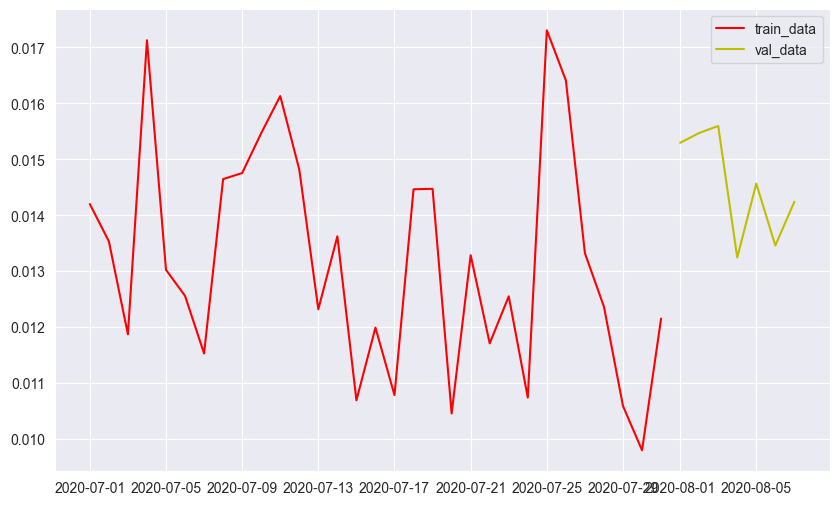

In [177]:
import matplotlib.pyplot as plt
# 第二步：预处理数据-由于所给数据本身就是单变量序列，并且没有空值，因此，可以不进行这一步处理
# 将数据分成训练集与验证集
val_size = 10
train_size = 10 * val_size
# train, val = data[-(train_size + val_size):-val_size + 1]['批发价格'], data[-val_size + 1:]['批发价格']
train, val = train_lst[0], valid_lst[0]
# plot the data
fig = plt.figure(figsize=(10, 6))
fig.add_subplot()
plt.plot(train, 'r-', label='train_data')
plt.plot(val, 'y-', label='val_data')

plt.legend(loc='best')
plt.show(block=False)


ARIMA训练

In [168]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-131.164, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-149.799, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-147.553, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-147.605, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-148.330, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-147.799, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-145.799, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-148.910, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-149.605, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-133.181, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-147.799, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.676 seconds


In [169]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [170]:
# 第四步:在验证集上进行预测
forecast = stepwise_model.predict(n_periods=len(val))
print(forecast)
forecast = pd.DataFrame(forecast, index=val.index, columns=['prediction'])

2020-08-01    0.008140
2020-08-02    0.010968
2020-08-03    0.009393
2020-08-04    0.010234
2020-08-05    0.008425
2020-08-06    0.014987
2020-08-07    0.014093
Freq: D, dtype: float64


RMSE : 0.0048


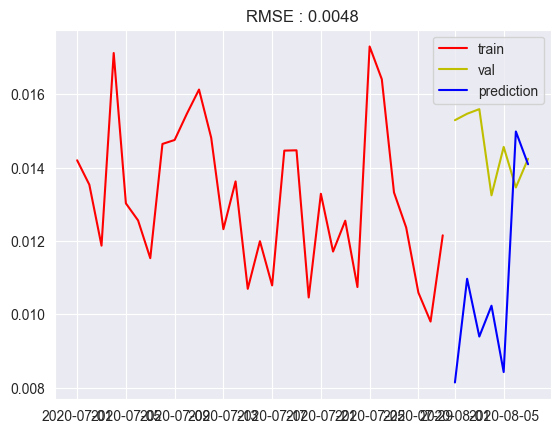

In [171]:
# calculate rmse
rmse = np.sqrt(mean_squared_error(val, forecast))
print('RMSE : %.4f' % rmse)

# plot predictions
fig = plt.figure()
fig.add_subplot()
plt.plot(train, 'r-', label='train')
plt.plot(val, 'y-', label='val')
plt.plot(forecast, 'b-', label='prediction')
plt.legend(loc='best')
plt.title('RMSE : %.4f' % rmse)
plt.show(block=False)
